# News Mood
## Observations
1) Sentiment varies significantly depending on the current news. I ran this on several days and got fairly different results each time. So it's hard to make generalizations.<br>
2) The majority of compound sentiment is within -0.75 and 0.75. There are few points outside that range.  
3) Textblob is more optimistic than Vader in analyzing sentiment. Textblob's sentiments are much more positive than Vader's composite sentiments.

## API KEYS HAVE BEEN REMOVED FOR SECURITY

In [1]:
# Dependencies
import tweepy
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
from textblob import TextBlob

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Twitter API Keys
### REMOVED FOR SECURITY

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
analyzer = SentimentIntensityAnalyzer()

In [3]:
# Target User
target_user_list = ["CNN", "BBC", "CBS", "Foxnews", "nytimes"]
######other media outlets to look at:  ,"npr","wsj","huffpost"

#create a dataframe to store the data in so it can easily be plotted using Seaborn
sd = pd.DataFrame(columns=['idx','Media Sources','compound','positive','neutral','negative','TBpolarity','text','date'])

#loop through target users
for target_user in target_user_list:
    print("User: ", target_user)
    # Create a list to record all compound sentiments for the current user
    compounds = []
    positives = []
    neutrals = []
    negatives=[]
    polarity=[]
    texts=[]
    dates=[]
    
    # Loop through 100 tweets, 20 at a time
    for x in range(5):
   
        # Get all tweets from target user
        public_tweets = api.user_timeline(target_user, page=x)
        #print("number of tweets: " + str(len(public_tweets)))
        
        # Loop through all tweets, get the compound sentiment, and add to list      
        for tweet in public_tweets:
            
            target_string = tweet['text']
            #print(target_string)
            
            #save the tweet time
            raw_time = tweet["created_at"]
            converted_time = datetime.strptime(raw_time, "%a %b %d %H:%M:%S %z %Y")
            
            dates.append(datetime.date(converted_time))
                                      

            #determine the sentiments and store in lists
            compound = analyzer.polarity_scores(target_string)["compound"]
            pos = analyzer.polarity_scores(target_string)["pos"]
            neu = analyzer.polarity_scores(target_string)["neu"]
            neg = analyzer.polarity_scores(target_string)["neg"]
            
            compounds.append(compound)
            positives.append(pos)
            negatives.append(neg)
            neutrals.append(neu)
            texts.append(target_string)
            
            #use Textblob to determine sentiment
            blob = TextBlob(target_string)
            polarity.append(blob.sentiment.polarity)
             
                        
            
        #end for public_tweets    
    #end page loop
    
    #set up dictionary for adding to the dataframe
    rl = list(range(len(compounds)))
    sentiment_dict = {"idx": rl,
                  "Media Sources": target_user,
                  "compound": compounds,
                     "positive":positives,
                     "negative": negatives,
                     "neutral": neutrals,
                      "TBpolarity": polarity,
                     "text": texts,
                     "date":dates}
    sdx = pd.DataFrame(sentiment_dict)
    sd = sd.append(sdx)       

sd.head(10)

#write to a CSV file
sd.to_csv("media_sentiment.csv",header=True)

#get current date
analysis_time = datetime.now().strftime("%m/%d/%y")    

User:  CNN
User:  BBC
User:  CBS
User:  Foxnews
User:  nytimes


In [4]:
sd.tail()

,Media Sources,TBpolarity,compound,date,idx,negative,neutral,positive,text
95,nytimes,-0.042857,0.4019,2017-11-05,95,0.00,0.876,0.124,"While you can’t control your age, you can slow..."
96,nytimes,0.000000,0.0772,2017-11-05,96,0.00,0.860,0.140,What do colleges want in an applicant? Everyth...
97,nytimes,0.000000,0.0000,2017-11-05,97,0.00,1.000,0.000,Opinion: And then they came for Robert Mueller...
98,nytimes,0.000000,-0.4767,2017-11-05,98,0.14,0.860,0.000,"2 months after Harvey, Houston still suffers f..."
99,nytimes,0.000000,0.0000,2017-11-05,99,0.00,1.000,0.000,A pizza for fall https://t.co/R4w3jIWsrH


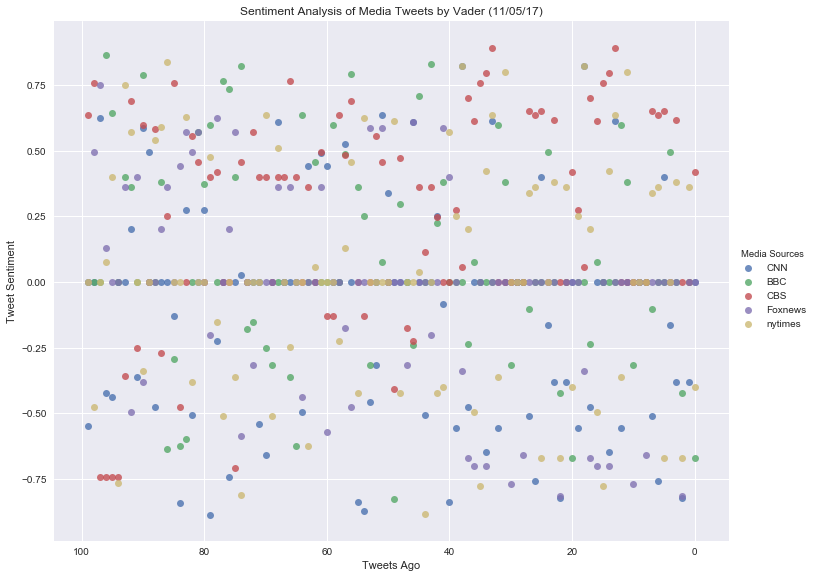

In [5]:
#PLOT IN SEABORN based on Vader compound sentiment
ax = sns.lmplot("idx", "compound", data=sd, hue='Media Sources', fit_reg=False, size=8,aspect=1.3,
               legend_out=True)

plt.title("Sentiment Analysis of Media Tweets by Vader (" + analysis_time + ")")
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Sentiment")

#invert the x axis 
plt.gca().invert_xaxis()

# Save the figure
plt.savefig("Sentiment_Analysis.png")

plt.show()

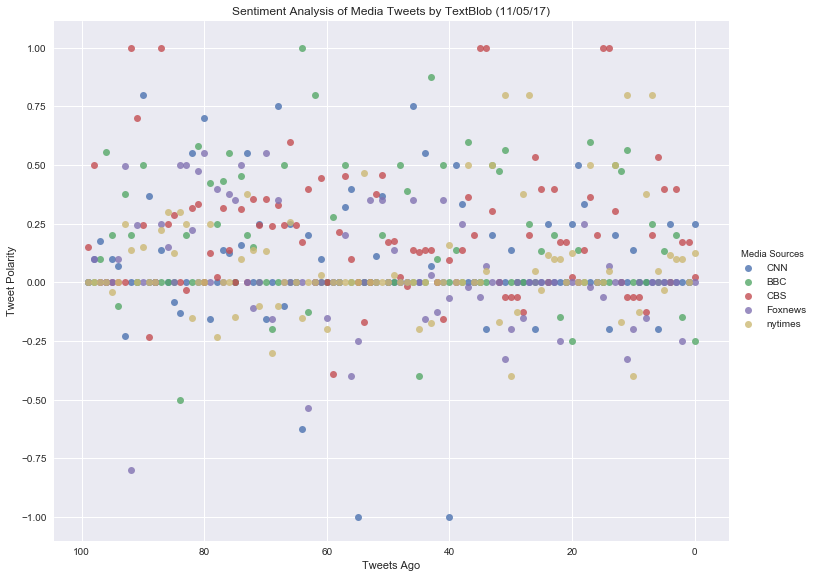

In [6]:
#plot based on the blob sentiment
#PLOT IN SEABORN
ax = sns.lmplot("idx", "TBpolarity", data=sd, hue='Media Sources', fit_reg=False, size=8,aspect=1.3,
               legend_out=True)

plt.title("Sentiment Analysis of Media Tweets by TextBlob (" + analysis_time + ")")
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")

#invert the x axis 
plt.gca().invert_xaxis()

# Save the figure
plt.savefig("Polarity_Analysis.png")

plt.show()

In [7]:
#aggregate the data for the mean compound sentiment bar plot
td = sd.groupby('Media Sources')
to_plot = pd.DataFrame(td['compound'].mean())
to_plot.reset_index(inplace=True)
to_plot


,Media Sources,compound
0,BBC,0.080034
1,CBS,0.230502
2,CNN,-0.112204
3,Foxnews,-0.034555
4,nytimes,0.029642


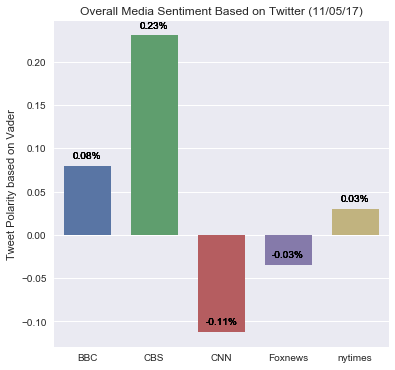

In [8]:
#Plot the overall compound sentiments in a bar plot
#bar plot visualizing the overall sentiments of the last 100 tweets from each organization. 

#function to make the bar width wider
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # change the bar width
        patch.set_width(new_value)

        # recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
#function to annotate the bars with the percentage
def annotateBars(row, ax=ax): 
    for p in ax.patches:
         ax.annotate('%.2f%%' % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
             textcoords='offset points')          

            
fig, ax = plt.subplots()
plt.title("Overall Media Sentiment Based on Twitter (" + analysis_time + ")")

g = sns.barplot(x="Media Sources", y="compound", data=to_plot)
g.figure.set_size_inches(6,6)

#make the bar width wider
change_width(ax, 0.7)

#add the annotation to the plot
plot = to_plot.apply(annotateBars, ax=ax, axis=1)

plt.ylabel("Tweet Polarity based on Vader")
plt.xlabel("")

#store in a file
plt.savefig("Overall_Sentiment.png")

plt.show()


In [9]:
#write to a CSV file
sd.to_csv("media_sentiment.csv",header=True)